### Imports

In [1]:
pip install annoy

     |████████████████████████████████| 646 kB 13.2 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391649 sha256=964fcf7a6e5dda5250d7c3d9fd26ff902876cbcf1041a1edf521245837615195
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

np.random.seed(42)
torch.cuda.set_device(0)

from annoy import AnnoyIndex

import glob

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creating DFs

In [5]:
#creating df of image names & dataset label (train, val, test)
img_partitions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/Eval/list_eval_partition.csv', sep="\t", header=1, error_bad_lines=False, encoding="euc-kr")
img_partitions['path'] = img_partitions['path'].replace("K-Fashion 이미지/원천데이터/레트로/","")
img_partitions

path evaluation_status
0                K-Fashion 이미지/원천데이터/레트로/(121)IMG_1.jpg               val
1                K-Fashion 이미지/원천데이터/레트로/(211)IMG_1.jpg               val
2     K-Fashion 이미지/원천데이터/레트로/018-285-4,257-35,865-H...               val
3     K-Fashion 이미지/원천데이터/레트로/019-286-3,261-39,126-H...             train
4     K-Fashion 이미지/원천데이터/레트로/1-(9)-004-271-3031-516...               val
...                                                 ...               ...
1176  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4876.jpg             train
1177  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4896.jpg             train
1178  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4916.jpg               val
1179  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...              test
1180  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...             train

[1181 rows x 2 columns]

In [6]:
'''
#creating df of image names & dataset label (train, val, test)
img_partitions = pd.read_csv('./Eval/list_eval_partition.txt', delim_whitespace=True, header=1)

#creating df of attribute names and type label
attributes = pd.read_csv(
    './Anno/list_attr_cloth.txt', 
    sep='\s{2,}', 
    header=0, 
    skiprows=[0], 
    engine='python')

attributes_imgs = pd.read_csv(
    './Anno/list_attr_img.txt', 
    delim_whitespace=True, 
    header=0,
    skiprows=[0],
    names=(['image_name'] + attributes['attribute_name'].tolist()))
attributes_imgs.replace([-1,0,1],[False,False,True], inplace=True)

#creating df of image names, attribute tags, and dataset label
attributes_df = attributes_imgs.merge(img_partitions, how ='left', on='image_name')'''

#creating df of attribute names and type label
attributes = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/Anno/list_attr_cloth.txt', 
    sep='\s{2,}', header=0, skiprows=[0], engine='python')
attributes.rename(columns={'material': 'detail'},inplace = True)
attributes

detail  attribute_type
0         비즈               1
1         단추               1
2      니트꽈배기               1
3         체인               1
4        컷오프               1
5    더블브레스티드               1
6       드롭숄더               1
7         자수               1
8         프릴               1
9        프린지               1
10       플레어               1
11        퀼팅               1
12        리본               1
13        롤업               1
14        러플               1
15        셔링               1
16        슬릿               1
17       스팽글               1
18       스티치               1
19       스터드               1
20      퍼트리밍               1
21       글리터               1
22        후드               1
23      레이스업               1
24        패딩               1
25      패치워크               1
26       페플럼               1
27       플리츠               1
28        포켓               1
29        폼폼               1
30        퍼프               1
31        태슬               1
32        집업               1
33         띠               1
34    디스트로이드               1
35    드롭웨이스트               1
36        버클               1
37       컷아웃               1
38      X스트랩               1
39       비대칭               1
40        셔링               1
41        체크               2
42     스트라이프               2
43      지그재그               2
44        호피               2
45       지브라               2
46        도트               2
47     카무플라쥬               2
48      페이즐리               2
49       아가일               2
50       플로럴               2
51       레터링               2
52        해골               2
53      타이다이               2
54     그라데이션               2
55        무지               2
56       그래픽               2
57    하운즈 투스               2
58        깅엄               2
59         퍼               3
60       무스탕               3
61      스웨이드               3
62       앙고라               3
63      코듀로이               3
64    시퀸/글리터               3
65        우븐               3
66        데님               3
67        저지               3
68       트위드               3
69        벨벳               3
70    비닐/PVC               3
71    울/캐시미어               3
72      합성섬유               3
73        니트               3
74       레이스               3
75        린넨               3
76        메시               3
77       플리스               3
78      네오프렌               3
79        실크               3
80      스판덱스               3
81       자카드               3
82        가죽               3
83         면               3
84        시폰               3
85       민소매               4
86        반팔               4
87         캡               4
88      7부소매               4
89        긴팔               4
90      라운드넥               5
91        유넥               5
92       브이넥               5
93       홀터넥               5
94      오프숄더               5
95      원 숄더               5
96      스퀘어넥               5
97       노카라               5
98        후드               5
99       터틀넥               5
100      보트넥               5
101    스위트하트               5
102     셔츠칼라               6
103     보우칼라               6
104    세일러칼라               6
105      숄칼라               6
106     폴로칼라               6
107    피터팬칼라               6
108    너치드칼라               6
109    차이나칼라               6
110   테일러드칼라               6
111     밴드칼라               6
112       노멀               7
113       루즈               7
114    오버사이즈               7
115      스키니               7
116      와이드               7
117      타이트               7
118      페플럼               8
119      비대칭               8
120     알수없음               8
121       펜슬               8
122      A라인               8
123      H라인               8
124     머메이드               8
125  벨보텀/플레어               8
126      부츠컷               8
127     테이퍼드               8
128    스트레이트               8

In [7]:
attributes_imgs = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/Anno/list_img.csv', 
   sep="\t", skiprows=[0],header=0, error_bad_lines=False, encoding="euc-kr",engine='python'
    )

# for data in attributes_imgs['material'] :
def img(x):
  if type(x) != str:
    return ""
  x = x.replace("['", "").replace("']", "").replace("', '", ",").split(",")
  return x[0]

attributes_imgs['material'] = attributes_imgs['material'].apply(lambda x: img(x))

attributes_imgs['print'] =  attributes_imgs['print'].apply(lambda x: img(x))

attributes_imgs['detail'] =  attributes_imgs['detail'].apply(lambda x: img(x))

attributes_imgs


path clothes  \
0                K-Fashion 이미지/원천데이터/레트로/(121)IMG_1.jpg      상의   
1                K-Fashion 이미지/원천데이터/레트로/(211)IMG_1.jpg      상의   
2     K-Fashion 이미지/원천데이터/레트로/018-285-4,257-35,865-H...     원피스   
3     K-Fashion 이미지/원천데이터/레트로/019-286-3,261-39,126-H...      상의   
4     K-Fashion 이미지/원천데이터/레트로/1-(9)-004-271-3031-516...      상의   
...                                                 ...     ...   
1176  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4876.jpg     원피스   
1177  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4896.jpg     원피스   
1178  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4916.jpg     원피스   
1179  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      상의   
1180  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      하의   

                                        name category color detail print  \
0                             (121)IMG_1.jpg     블라우스   네이비          플로럴   
1                             (211)IMG_1.jpg     블라우스   베이지    페플럼   플로럴   
2      018-285-4,257-35,865-Hanna_409_07.jpg      드레스   화이트     퍼프    깅엄   
3     019-286-3,261-39,126-Haemil_194_06.jpg     니트웨어    와인           무지   
4     1-(9)-004-271-3031-5163-TOP_179_11.jpg     블라우스   화이트          그래픽   
...                                      ...      ...   ...    ...   ...   
1176               없음-994-994-완-DSC_4876.jpg      드레스    와인    플레어   플로럴   
1177               없음-994-994-완-DSC_4896.jpg      드레스    와인    플레어   플로럴   
1178               없음-994-994-완-DSC_4916.jpg      드레스    와인    플레어   플로럴   
1179      팬츠-1-u_155677953310-001 (1995).jpg     니트웨어   베이지          아가일   
1180      팬츠-1-u_155677953310-001 (1995).jpg       팬츠    핑크     롤업         

     material length neckline  collar fit  shape  
0          우븐     긴팔      NaN     NaN  루즈    NaN  
1          시폰     긴팔      NaN     NaN  노멀    NaN  
2          우븐     반팔    스위트하트     NaN  루즈    NaN  
3          니트   7부소매      터틀넥     NaN  노멀    NaN  
4          우븐   7부소매     라운드넥     NaN  루즈    NaN  
...       ...    ...      ...     ...  ..    ...  
1176       우븐     긴팔      NaN     NaN  노멀    NaN  
1177       우븐     긴팔      NaN     NaN  노멀    NaN  
1178       우븐     긴팔      NaN     NaN  노멀    NaN  
1179       니트     긴팔     라운드넥     NaN  노멀    NaN  
1180       우븐    NaN      NaN     NaN  노멀    NaN  

[1181 rows x 13 columns]

In [8]:
#creating df of image names, attribute tags, and dataset label
#attributes_imgs.replace([-1,0,1],[False,False,True], inplace=True)
attributes_imgs = pd.merge(attributes_imgs, attributes, how='left', on='detail')
attributes_df = pd.merge(attributes_imgs, img_partitions, how='left', on='path')

attributes_df

path clothes  \
0                K-Fashion 이미지/원천데이터/레트로/(121)IMG_1.jpg      상의   
1                K-Fashion 이미지/원천데이터/레트로/(211)IMG_1.jpg      상의   
2                K-Fashion 이미지/원천데이터/레트로/(211)IMG_1.jpg      상의   
3     K-Fashion 이미지/원천데이터/레트로/018-285-4,257-35,865-H...     원피스   
4     K-Fashion 이미지/원천데이터/레트로/019-286-3,261-39,126-H...      상의   
...                                                 ...     ...   
2022  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4916.jpg     원피스   
2023  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      상의   
2024  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      상의   
2025  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      하의   
2026  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      하의   

                                        name category color detail print  \
0                             (121)IMG_1.jpg     블라우스   네이비          플로럴   
1                             (211)IMG_1.jpg     블라우스   베이지    페플럼   플로럴   
2                             (211)IMG_1.jpg     블라우스   베이지    페플럼   플로럴   
3      018-285-4,257-35,865-Hanna_409_07.jpg      드레스   화이트     퍼프    깅엄   
4     019-286-3,261-39,126-Haemil_194_06.jpg     니트웨어    와인           무지   
...                                      ...      ...   ...    ...   ...   
2022               없음-994-994-완-DSC_4916.jpg      드레스    와인    플레어   플로럴   
2023      팬츠-1-u_155677953310-001 (1995).jpg     니트웨어   베이지          아가일   
2024      팬츠-1-u_155677953310-001 (1995).jpg     니트웨어   베이지          아가일   
2025      팬츠-1-u_155677953310-001 (1995).jpg       팬츠    핑크     롤업         
2026      팬츠-1-u_155677953310-001 (1995).jpg       팬츠    핑크     롤업         

     material length neckline  collar fit  shape  attribute_type  \
0          우븐     긴팔      NaN     NaN  루즈    NaN             NaN   
1          시폰     긴팔      NaN     NaN  노멀    NaN             1.0   
2          시폰     긴팔      NaN     NaN  노멀    NaN             8.0   
3          우븐     반팔    스위트하트     NaN  루즈    NaN             1.0   
4          니트   7부소매      터틀넥     NaN  노멀    NaN             NaN   
...       ...    ...      ...     ...  ..    ...             ...   
2022       우븐     긴팔      NaN     NaN  노멀    NaN             1.0   
2023       니트     긴팔     라운드넥     NaN  노멀    NaN             NaN   
2024       니트     긴팔     라운드넥     NaN  노멀    NaN             NaN   
2025       우븐    NaN      NaN     NaN  노멀    NaN             1.0   
2026       우븐    NaN      NaN     NaN  노멀    NaN             1.0   

     evaluation_status  
0                  val  
1                  val  
2                  val  
3                  val  
4                train  
...                ...  
2022               val  
2023              test  
2024             train  
2025              test  
2026             train  

[2027 rows x 15 columns]

In [9]:
#removing images from DF with no label
#training_df['max'] = [training_df.iloc[x][1:].max() for x in training_df.index.tolist()]
#training_df = training_df[training_df['max'].isin([True])].copy()
#training_df.drop('max', axis=1, inplace=True)
attributes_df['detail']=attributes_df['detail'].dropna()
attributes_df

path clothes  \
0                K-Fashion 이미지/원천데이터/레트로/(121)IMG_1.jpg      상의   
1                K-Fashion 이미지/원천데이터/레트로/(211)IMG_1.jpg      상의   
2                K-Fashion 이미지/원천데이터/레트로/(211)IMG_1.jpg      상의   
3     K-Fashion 이미지/원천데이터/레트로/018-285-4,257-35,865-H...     원피스   
4     K-Fashion 이미지/원천데이터/레트로/019-286-3,261-39,126-H...      상의   
...                                                 ...     ...   
2022  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4916.jpg     원피스   
2023  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      상의   
2024  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      상의   
2025  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      하의   
2026  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      하의   

                                        name category color detail print  \
0                             (121)IMG_1.jpg     블라우스   네이비          플로럴   
1                             (211)IMG_1.jpg     블라우스   베이지    페플럼   플로럴   
2                             (211)IMG_1.jpg     블라우스   베이지    페플럼   플로럴   
3      018-285-4,257-35,865-Hanna_409_07.jpg      드레스   화이트     퍼프    깅엄   
4     019-286-3,261-39,126-Haemil_194_06.jpg     니트웨어    와인           무지   
...                                      ...      ...   ...    ...   ...   
2022               없음-994-994-완-DSC_4916.jpg      드레스    와인    플레어   플로럴   
2023      팬츠-1-u_155677953310-001 (1995).jpg     니트웨어   베이지          아가일   
2024      팬츠-1-u_155677953310-001 (1995).jpg     니트웨어   베이지          아가일   
2025      팬츠-1-u_155677953310-001 (1995).jpg       팬츠    핑크     롤업         
2026      팬츠-1-u_155677953310-001 (1995).jpg       팬츠    핑크     롤업         

     material length neckline  collar fit  shape  attribute_type  \
0          우븐     긴팔      NaN     NaN  루즈    NaN             NaN   
1          시폰     긴팔      NaN     NaN  노멀    NaN             1.0   
2          시폰     긴팔      NaN     NaN  노멀    NaN             8.0   
3          우븐     반팔    스위트하트     NaN  루즈    NaN             1.0   
4          니트   7부소매      터틀넥     NaN  노멀    NaN             NaN   
...       ...    ...      ...     ...  ..    ...             ...   
2022       우븐     긴팔      NaN     NaN  노멀    NaN             1.0   
2023       니트     긴팔     라운드넥     NaN  노멀    NaN             NaN   
2024       니트     긴팔     라운드넥     NaN  노멀    NaN             NaN   
2025       우븐    NaN      NaN     NaN  노멀    NaN             1.0   
2026       우븐    NaN      NaN     NaN  노멀    NaN             1.0   

     evaluation_status  
0                  val  
1                  val  
2                  val  
3                  val  
4                train  
...                ...  
2022               val  
2023              test  
2024             train  
2025              test  
2026             train  

[2027 rows x 15 columns]

In [10]:
from fastai import *
from fastai.vision import *

np.random.seed(42)
torch.cuda.set_device(0)

In [11]:
training_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][['detail','name']].copy()

#One Hot Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = training_df.iloc[:, :].values
X= pd.DataFrame(X, columns=['detail','name'])
print(X)
'''
le = LabelEncoder()
print('****************************')
X[0] = le.fit_transform(X[0])
print(X)

ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [0])],   # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
    remainder='passthrough'                                         # Leave the rest of the columns untouched
)
print('****************************')
X = ct.fit_transform(X[0]).toarray()
print(X)
'''

pandas_one_hot_encoded = pd.get_dummies(X['detail'])

pandas_with_onehot = pd.concat(
    [DataFrame(X['name']),pandas_one_hot_encoded],axis=1)
pandas_with_onehot.replace([-1,0,1],[False,False,True], inplace=True)
print(pandas_with_onehot)


pandas_with_onehot.to_csv('/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/Anno/OHEmaterial.csv', mode='w',encoding='utf-8-sig', header=True)
'''
csvfile = open('/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/Anno/OHEmaterial.csv', 
   "w",newline="")

csvwriter = csv.writer(csvfile)
for rows in pandas_with_onehot :
  csvwriter.writerows(rows)

csvfile.close()
'''
'''
training_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][['name']].copy()
print(training_df)
print('****************************')
OHE_df = pd.concat(training_df, ohe)
OHE_df
'''
ohe = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/Anno/OHEmaterial.csv'
    )
print(ohe)
ohe=ohe.drop([ohe.columns[0],ohe.columns[2]],axis=1)
ohe

#attributes_df2 = ohe.merge(attributes_df, how ='left', on='name')
#attributes_df2

#training_df2 = attributes_df2[attributes_df2['evaluation_status'].isin(['train','val'])].copy()
#training_df2.reset_index(drop=True, inplace=True)
#training_df2 = training_df2.drop([training_df2.columns[19],training_df2.columns[20],training_df2.columns[21],training_df2.columns[22],training_df2.columns[23],training_df2.columns[24],training_df2.columns[25],training_df2.columns[26],training_df2.columns[27],training_df2.columns[28],training_df2.columns[29],training_df2.columns[30],training_df2.columns[31],training_df2.columns[32],training_df2.columns[33]],axis=1)
#training_df2

     detail                                    name
0                                    (121)IMG_1.jpg
1       페플럼                          (211)IMG_1.jpg
2       페플럼                          (211)IMG_1.jpg
3        퍼프   018-285-4,257-35,865-Hanna_409_07.jpg
4            019-286-3,261-39,126-Haemil_194_06.jpg
...     ...                                     ...
1375    플레어               없음-994-994-완-DSC_4876.jpg
1376    플레어               없음-994-994-완-DSC_4896.jpg
1377    플레어               없음-994-994-완-DSC_4916.jpg
1378             팬츠-1-u_155677953310-001 (1995).jpg
1379     롤업      팬츠-1-u_155677953310-001 (1995).jpg

[1380 rows x 2 columns]
                                        name           글리터  니트꽈베기     단추  \
0                             (121)IMG_1.jpg   True  False  False  False   
1                             (211)IMG_1.jpg  False  False  False  False   
2                             (211)IMG_1.jpg  False  False  False  False   
3      018-285-4,257-35,865-Hanna_409_07.jpg  F

name    글리터  니트꽈베기     단추  더블브레스티드  \
0                             (121)IMG_1.jpg  False  False  False    False   
1                             (211)IMG_1.jpg  False  False  False    False   
2                             (211)IMG_1.jpg  False  False  False    False   
3      018-285-4,257-35,865-Hanna_409_07.jpg  False  False  False    False   
4     019-286-3,261-39,126-Haemil_194_06.jpg  False  False  False    False   
...                                      ...    ...    ...    ...      ...   
1375               없음-994-994-완-DSC_4876.jpg  False  False  False    False   
1376               없음-994-994-완-DSC_4896.jpg  False  False  False    False   
1377               없음-994-994-완-DSC_4916.jpg  False  False  False    False   
1378      팬츠-1-u_155677953310-001 (1995).jpg  False  False  False    False   
1379      팬츠-1-u_155677953310-001 (1995).jpg  False  False  False    False   

       드롭숄더  드롭웨이스트  디스트로이드      띠     러플    레이스     롤업     리본     버클    비대칭  \
0     False   False   False  False  False  False  False  False  False  False   
1     False   False   False  False  False  False  False  False  False  False   
2     False   False   False  False  False  False  False  False  False  False   
3     False   False   False  False  False  False  False  False  False  False   
4     False   False   False  False  False  False  False  False  False  False   
...     ...     ...     ...    ...    ...    ...    ...    ...    ...    ...   
1375  False   False   False  False  False  False  False  False  False  False   
1376  False   False   False  False  False  False  False  False  False  False   
1377  False   False   False  False  False  False  False  False  False  False   
1378  False   False   False  False  False  False  False  False  False  False   
1379  False   False   False  False  False  False   True  False  False  False   

         비즈     셔링    스트링    스티치     슬릿  싱글브레스티드     자수     지퍼     체인    컷아웃  \
0     False  False  False  False  False    False  False  False  False  False   
1     False  False  False  False  False    False  False  False  False  False   
2     False  False  False  False  False    False  False  False  False  False   
3     False  False  False  False  False    False  False  False  False  False   
4     False  False  False  False  False    False  False  False  False  False   
...     ...    ...    ...    ...    ...      ...    ...    ...    ...    ...   
1375  False  False  False  False  False    False  False  False  False  False   
1376  False  False  False  False  False    False  False  False  False  False   
1377  False  False  False  False  False    False  False  False  False  False   
1378  False  False  False  False  False    False  False  False  False  False   
1379  False  False  False  False  False    False  False  False  False  False   

         태슬   패치워크   퍼트리밍     퍼프    페플럼     포켓     폼폼    프린지     프릴    플레어  \
0     False  False  False  False  False  False  False  False  False  False   
1     False  False  False  False   True  False  False  False  False  False   
2     False  False  False  False   True  False  False  False  False  False   
3     False  False  False   True  False  False  False  False  False  False   
4     False  False  False  False  False  False  False  False  False  False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1375  False  False  False  False  False  False  False  False  False   True   
1376  False  False  False  False  False  False  False  False  False   True   
1377  False  False  False  False  False  False  False  False  False   True   
1378  False  False  False  False  False  False  False  False  False  False   
1379  False  False  False  False  False  False  False  False  False  False   

        플리츠  
0     False  
1     False  
2     False  
3     False  
4     False  
...     ...  
1375  False  
1376  False  
1377  False  
1378  False  
1379  False  

[1380 rows x 36 columns]

In [12]:
def count_attr_imgs(attr_df):
    col_counts = {}

    for col in attr_df.columns[1:]:
        col_counts[col] = attr_df[col].value_counts().to_frame().loc[True][0]
    
    col_df = pd.DataFrame.from_dict(col_counts, orient='index', columns=['Count'])
    
    return col_df
#.sort_values(by='Count')

## Baseline Model (No Data Cleaning)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52628 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49492 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47553 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53011 missing from current font.
  font.set_

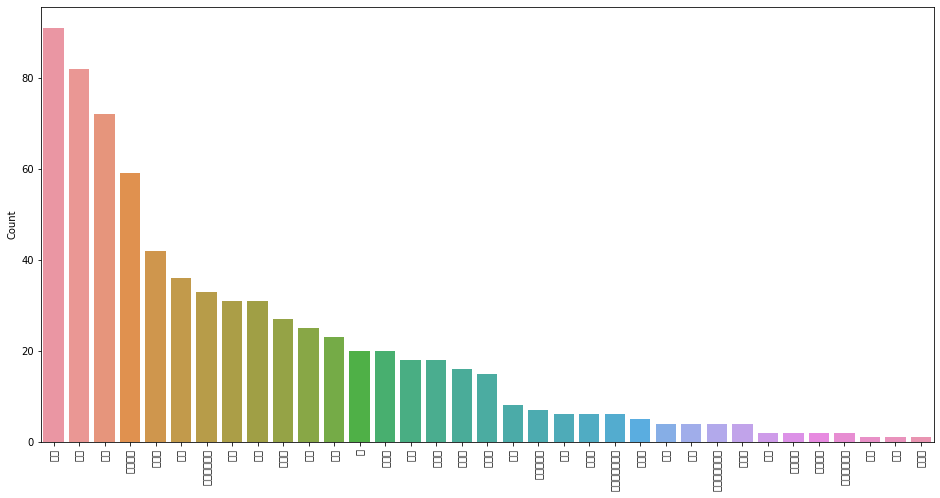

In [13]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(ohe).sort_values(by='Count',ascending=False).index,y=count_attr_imgs(ohe).sort_values(by='Count',ascending=False)['Count'])
plt.xticks(rotation=90);

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52628 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49492 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47553 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53011 missing from current font.
  font.set_

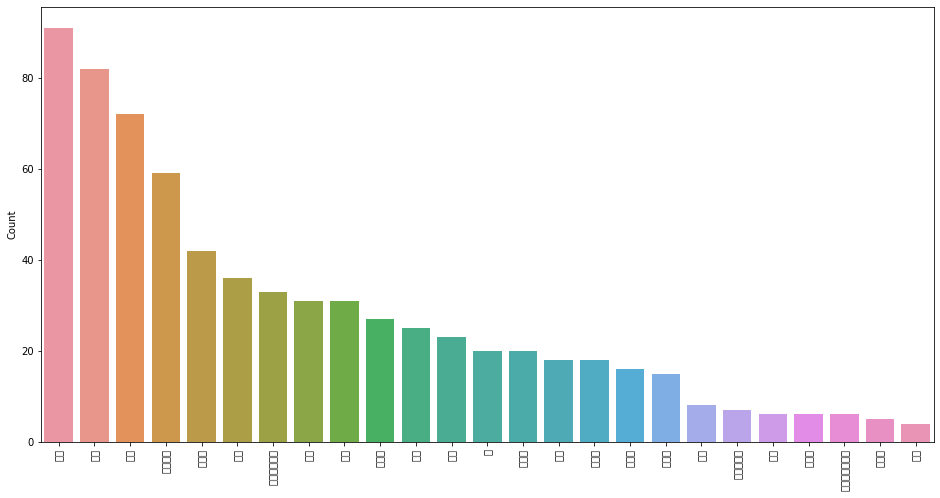

In [16]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(ohe).sort_values(by='Count',ascending=False)[:25].index,y=count_attr_imgs(ohe).sort_values(by='Count',ascending=False)[:25]['Count'])
plt.xticks(rotation=90);

In [17]:
# take all the columns after the first "image_name" col
label_column_names = ohe.columns.tolist()[1:]
label_column_names


img_base_path = Path("/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/K-Fashion 이미지/원천데이터/레트로/")
data = ImageDataBunch.from_df(img_base_path, ohe, ds_tfms=get_transforms(), size=150,label_col=label_column_names)
data.normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

ImageDataBunch;

Train: LabelList (1104 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
,페플럼,페플럼,퍼프,
Path: /content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/K-Fashion 이미지/원천데이터/레트로;

Valid: LabelList (276 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
단추,포켓,퍼트리밍,비대칭,단추
Path: /content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/K-Fashion 이미지/원천데이터/레트로;

Test: None

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

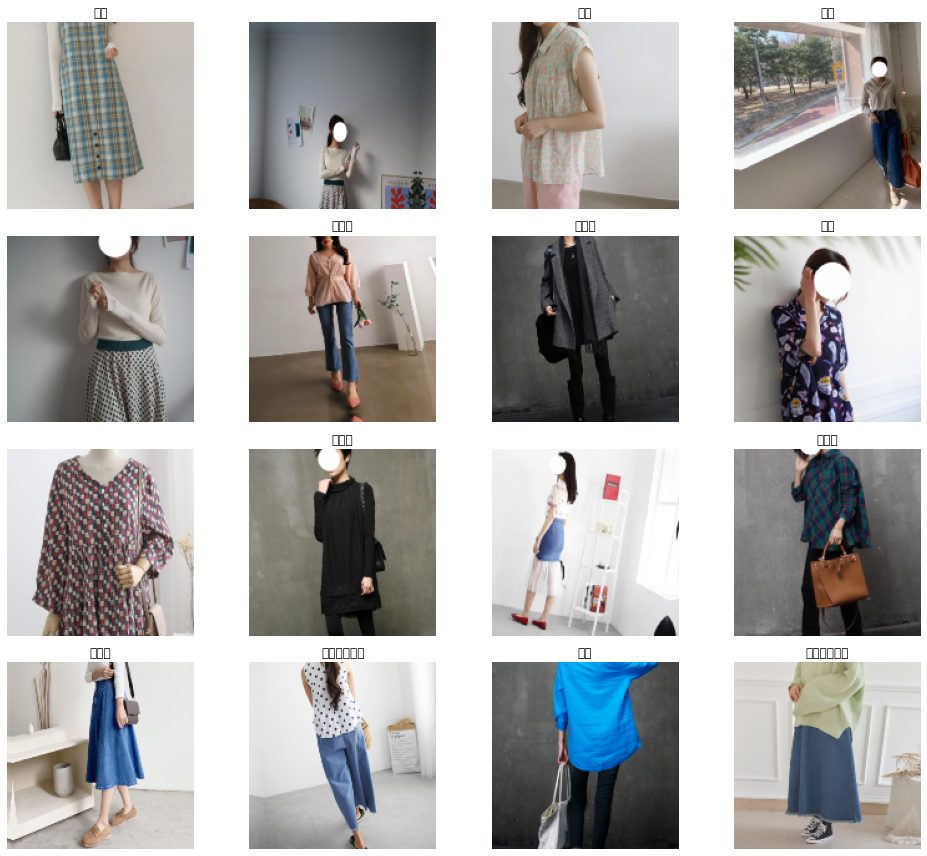

In [18]:
data.show_batch(rows=4, figsize=(14,12))

In [19]:
print(data.classes)
len(data.classes),data.c


['글리터', '니트꽈베기', '단추', '더블브레스티드', '드롭숄더', '드롭웨이스트', '디스트로이드', '띠', '러플', '레이스', '롤업', '리본', '버클', '비대칭', '비즈', '셔링', '스트링', '스티치', '슬릿', '싱글브레스티드', '자수', '지퍼', '체인', '컷아웃', '태슬', '패치워크', '퍼트리밍', '퍼프', '페플럼', '포켓', '폼폼', '프린지', '프릴', '플레어', '플리츠']


(35, 35)

In [20]:
acc_02 = partial(accuracy_thresh, thresh=0.1)
f_score = partial(fbeta, thresh=0.1)

In [21]:
learn = cnn_learner(data, models.resnet50, metrics=[acc_02, f_score], callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

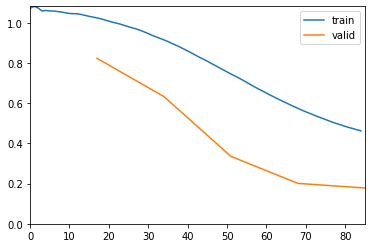

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for i

In [22]:
learn.fit_one_cycle(5)

In [ ]:
learn.lr_find()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


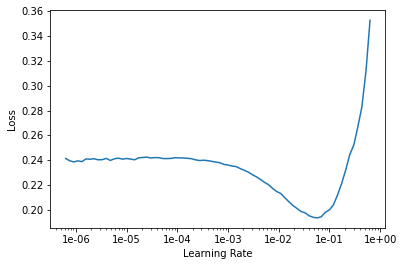

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

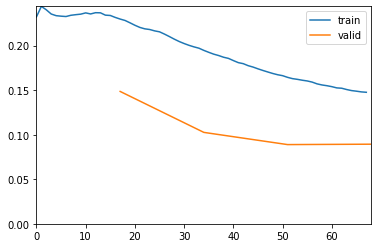

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default

In [ ]:
learn.fit_one_cycle(4, slice(1e-5,1e-3))

In [ ]:
learn.save('shape-resnet50-size150-fr5-unfr4', return_path=True)
learn.export('shape-resnet50-size150-fr5-unfr4.pkl')

In [ ]:
predict_img_path = "floral_dress.jpg" 
category,classIndex,losses = learn.predict(open_image(predict_img_path))
predictions = sorted(zip(data.classes, map(float, losses)), key=lambda p: p[1], reverse=True)
print (predictions[:5])
show_image(open_image(predict_img_path))

# "/data/Michael/data/predict/2.png"

FileNotFoundError: ignored